In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from factor_analyzer import calculate_bartlett_sphericity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Cargado de datos

In [2]:
df = pd.read_csv('dataset/kline.csv', sep=';')
df.shape

(630691, 15)

# Criptomonedas

## Compresión de los datos

In [3]:
df.head()

open_time     open     high      low    close     volume  \
0  1577836800000  0.19285  0.19297  0.19219  0.19248  1339147.7   
1  1577840400000  0.19243  0.19372  0.19237  0.19371  2339976.0   
2  1577844000000  0.19371  0.19454  0.19325  0.19418  2275718.8   
3  1577847600000  0.19419  0.19427  0.19371  0.19397   972145.7   
4  1577851200000  0.19397  0.19410  0.19351  0.19363  1176061.9   

      close_time   quote_volume  count  taker_buy_volume  \
0  1577840399999  257925.439502   1278          479957.5   
1  1577843999999  452060.925165   2249         1453722.0   
2  1577847599999  441494.831939   1509         1552864.6   
3  1577851199999  188606.109345   1066          480068.8   
4  1577854799999  227937.280398   1077          770127.9   

   taker_buy_quote_volume  ignore ticker        open_datetime  \
0            92429.917586       0    XRP  2020-01-01 00:00:00   
1           280854.952488       0    XRP  2020-01-01 01:00:00   
2           301337.420868       0    XRP  2020-01-01 02:00:00   
3            93134.098773       0    XRP  2020-01-01 03:00:00   
4           149272.489365       0    XRP  2020-01-01 04:00:00   

            close_datetime  
0  2020-01-01 00:59:59.999  
1  2020-01-01 01:59:59.999  
2  2020-01-01 02:59:59.999  
3  2020-01-01 03:59:59.999  
4  2020-01-01 04:59:59.999

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630691 entries, 0 to 630690
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   open_time               630691 non-null  int64  
 1   open                    630691 non-null  float64
 2   high                    630691 non-null  float64
 3   low                     630691 non-null  float64
 4   close                   630691 non-null  float64
 5   volume                  630691 non-null  float64
 6   close_time              630691 non-null  int64  
 7   quote_volume            630691 non-null  float64
 8   count                   630691 non-null  int64  
 9   taker_buy_volume        630691 non-null  float64
 10  taker_buy_quote_volume  630691 non-null  float64
 11  ignore                  630691 non-null  int64  
 12  ticker                  630691 non-null  object 
 13  open_datetime           630691 non-null  object 
 14  close_datetime      

Eliminamos datos irrelevantes

In [5]:
df = df.drop(['ignore'], axis=1)
df['open_datetime'] = pd.to_datetime(df['open_datetime'])
df['close_datetime'] = pd.to_datetime(df['close_datetime'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630691 entries, 0 to 630690
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   open_time               630691 non-null  int64         
 1   open                    630691 non-null  float64       
 2   high                    630691 non-null  float64       
 3   low                     630691 non-null  float64       
 4   close                   630691 non-null  float64       
 5   volume                  630691 non-null  float64       
 6   close_time              630691 non-null  int64         
 7   quote_volume            630691 non-null  float64       
 8   count                   630691 non-null  int64         
 9   taker_buy_volume        630691 non-null  float64       
 10  taker_buy_quote_volume  630691 non-null  float64       
 11  ticker                  630691 non-null  object        
 12  open_datetime           630691

In [7]:
numcols = [
    'open',
    'high',
    'low',
    'close',
    'volume', 
    'quote_volume',            
    'count',                   
    'taker_buy_volume',        
    'taker_buy_quote_volume'
]

In [8]:
df['ticker'].unique()

array(['XRP', 'ETH', 'DOT', 'SHIB', 'BTC', 'XLM', 'LINK', 'AVAX', 'SOL',
       'MATIC', 'FET', 'GRT', 'LTC', 'UNI', 'DOGE', 'NEAR', 'CHZ', 'ADA',
       'BCH', 'APE'], dtype=object)

## Limpieza de datos

* Revisamos que no existen datos faltantes

In [9]:
df.isna().sum()

open_time                 0
open                      0
high                      0
low                       0
close                     0
volume                    0
close_time                0
quote_volume              0
count                     0
taker_buy_volume          0
taker_buy_quote_volume    0
ticker                    0
open_datetime             0
close_datetime            0
dtype: int64

## Visualización de los datos

La visualización de los datos resultará dificil debido a que se encuentran mezclados datos de lineas de tiempo de distintas variables, por lo cual se utilizara otro tipo de visualización en un paso siguiente

## Exploración de los datos

In [91]:
from itertools import combinations

def evalute_normal_dist(df):
    results = []
    for col in df.columns:
        hip = ss.shapiro(df[col])
        results.append((col, hip))
    for result in results:
        print(result[0])
        if result[1][1] > 0.05:
            print("  Tiene distribución normal.")
        else:
            print("  NO tiene distribución normal.")

def evalute_corr(df, min_corr=0.9):
    results = []
    for col1, col2 in combinations(df.columns, 2):
        res = ss.spearmanr(df[col1], df[col2])
        results.append((col1, col2, res))
    print("Correlación")
    for result in sorted(results, reverse=True, key=lambda x: x[2][0]):
        if result[2][1] < 0.05 and abs(result[2][0]) > min_corr:
            print(f"{result[0]} | {result[1]}")
            print(f"  corr={round(result[2][0], 6)}")

### Test de distribución normal

In [11]:
evalute_normal_dist(df[numcols])

c:\Users\Cesar\Documents\GitHub\ML-TF\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 630691.
  res = hypotest_fun_out(*samples, **kwds)


open
  NO tiene distribución normal.
high
  NO tiene distribución normal.
low
  NO tiene distribución normal.
close
  NO tiene distribución normal.
volume
  NO tiene distribución normal.
quote_volume
  NO tiene distribución normal.
count
  NO tiene distribución normal.
taker_buy_volume
  NO tiene distribución normal.
taker_buy_quote_volume
  NO tiene distribución normal.


### Evaluación de correlación

Al tener solo columnas sin distribución normal la correlacion se medira utilizando la correlación de Spearman

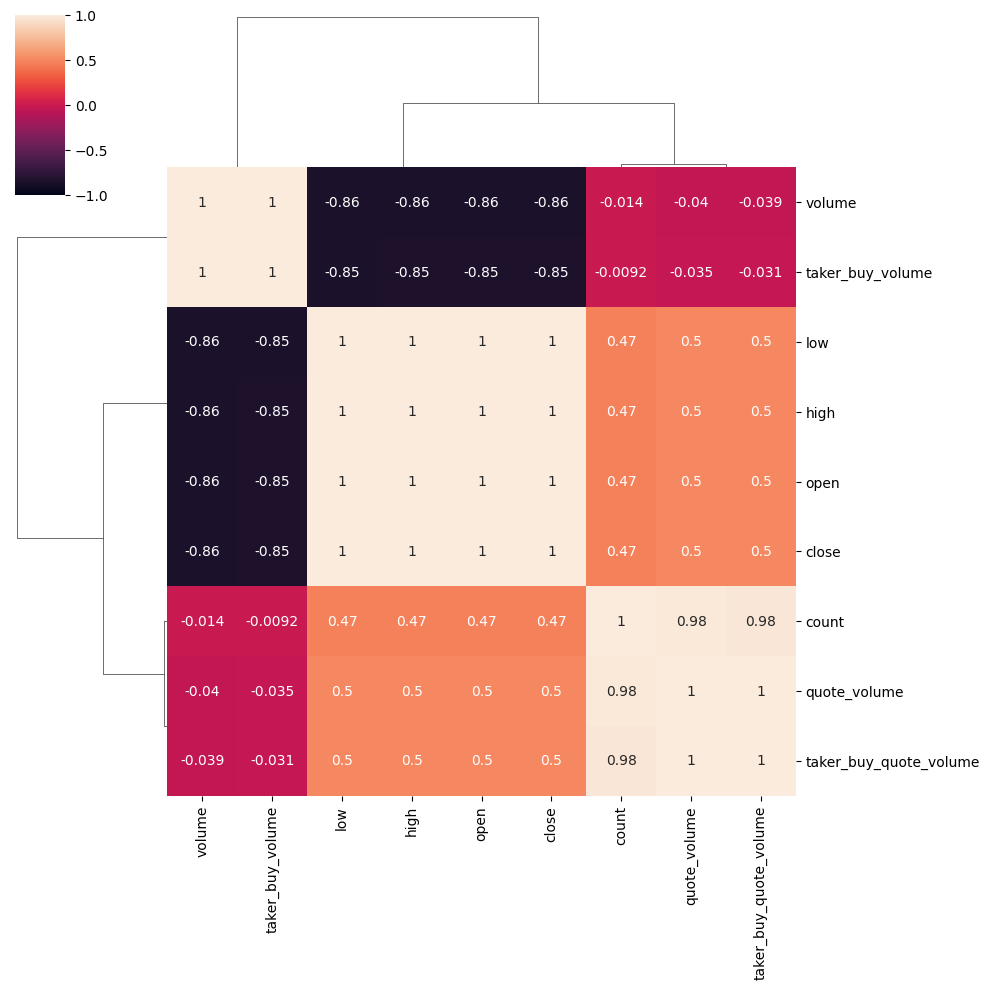

In [12]:
sns.clustermap(df[numcols].corr(method='spearman'), annot=True, vmin=-1, vmax=1)

In [13]:
evalute_corr(df[numcols])

Correlación
open | high
  corr=0.999991
open | low
  corr=0.99999
open | close
  corr=0.99999
high | low
  corr=0.999981
high | close
  corr=0.999994
low | close
  corr=0.99999
volume | taker_buy_volume
  corr=0.998111
quote_volume | count
  corr=0.978491
quote_volume | taker_buy_quote_volume
  corr=0.997263
count | taker_buy_quote_volume
  corr=0.97585


## Transformación de los datos

### Creación de variables

#### Nuevas variables como función

Definimos grupos de variables relacionadas con el precio, la moneda de cotización y el volumen

In [14]:
price_cols = ['open', 'low', 'high', 'close']
quote_cols = ['count', 'quote_volume', 'taker_buy_quote_volume']
volume_cols = ['volume', 'taker_buy_volume']

Creamos una variable para precio como promedio del precio máximo, mínimo, de apertura y cierre

In [15]:
df['id'] = df.index
df['mean_price'] = df[price_cols].sum(axis=1)/4
df['median_price'] = np.median(df[price_cols], axis=1)

In [16]:
df.head(5)

open_time     open     high      low    close     volume  \
0  1577836800000  0.19285  0.19297  0.19219  0.19248  1339147.7   
1  1577840400000  0.19243  0.19372  0.19237  0.19371  2339976.0   
2  1577844000000  0.19371  0.19454  0.19325  0.19418  2275718.8   
3  1577847600000  0.19419  0.19427  0.19371  0.19397   972145.7   
4  1577851200000  0.19397  0.19410  0.19351  0.19363  1176061.9   

      close_time   quote_volume  count  taker_buy_volume  \
0  1577840399999  257925.439502   1278          479957.5   
1  1577843999999  452060.925165   2249         1453722.0   
2  1577847599999  441494.831939   1509         1552864.6   
3  1577851199999  188606.109345   1066          480068.8   
4  1577854799999  227937.280398   1077          770127.9   

   taker_buy_quote_volume ticker       open_datetime          close_datetime  \
0            92429.917586    XRP 2020-01-01 00:00:00 2020-01-01 00:59:59.999   
1           280854.952488    XRP 2020-01-01 01:00:00 2020-01-01 01:59:59.999   
2           301337.420868    XRP 2020-01-01 02:00:00 2020-01-01 02:59:59.999   
3            93134.098773    XRP 2020-01-01 03:00:00 2020-01-01 03:59:59.999   
4           149272.489365    XRP 2020-01-01 04:00:00 2020-01-01 04:59:59.999   

   id  mean_price  median_price  
0   0    0.192623      0.192665  
1   1    0.193057      0.193070  
2   2    0.193920      0.193945  
3   3    0.194035      0.194080  
4   4    0.193802      0.193800

##### Visualizaciones conociendo los variables agrupadas

In [17]:
def plot_by_id(cols, ylabel):
    plt.figure(figsize=(20, 6))
    for col in cols:
        sns.scatterplot(data=df, x='id', y=col, label=col, s=10)
    plt.xlabel('Row Index')
    plt.ylabel(ylabel)
    plt.title(f'Scatter Plot of {ylabel} by Row')
    plt.legend()
    plt.show()

c:\Users\Cesar\Documents\GitHub\ML-TF\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


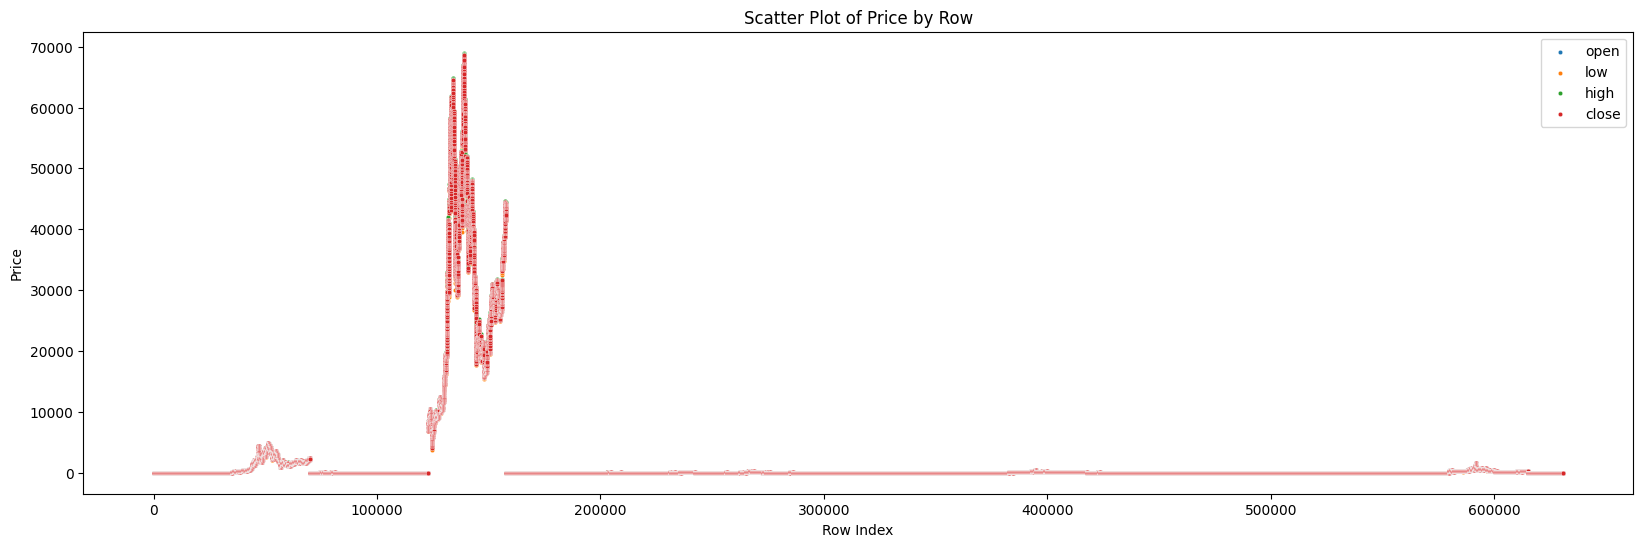

In [18]:
plot_by_id(price_cols, 'Price')

c:\Users\Cesar\Documents\GitHub\ML-TF\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


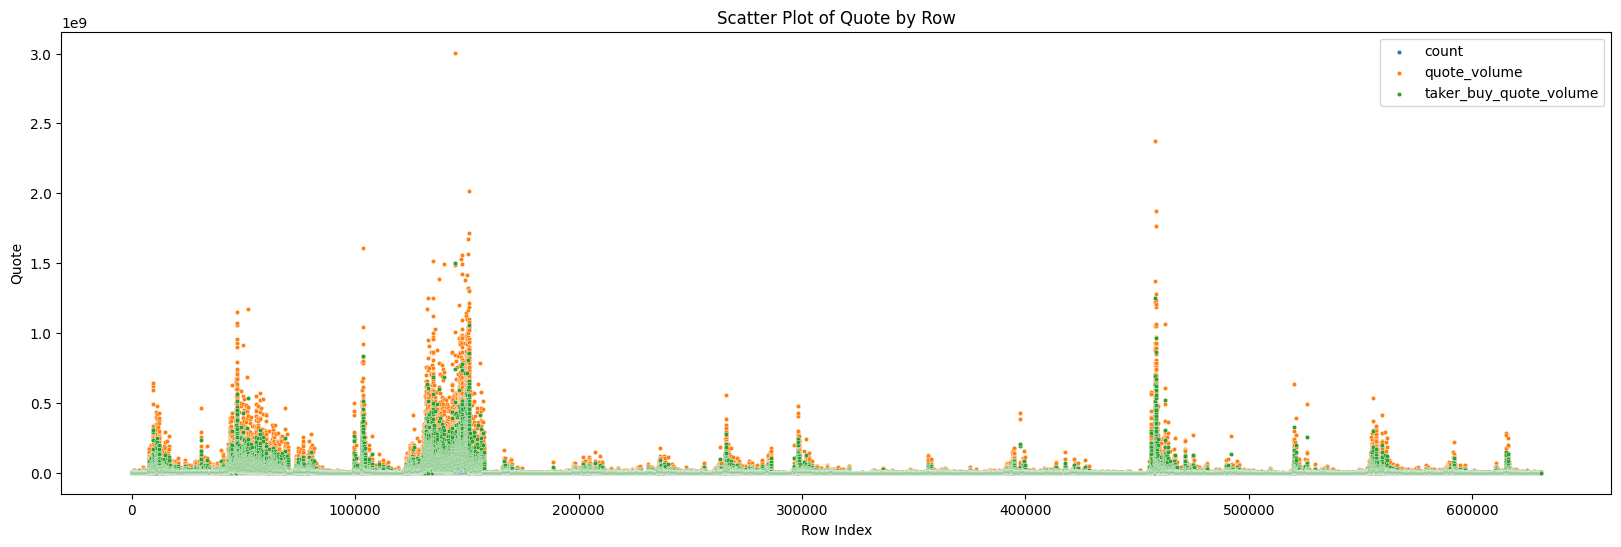

In [19]:
plot_by_id(quote_cols, 'Quote')

c:\Users\Cesar\Documents\GitHub\ML-TF\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


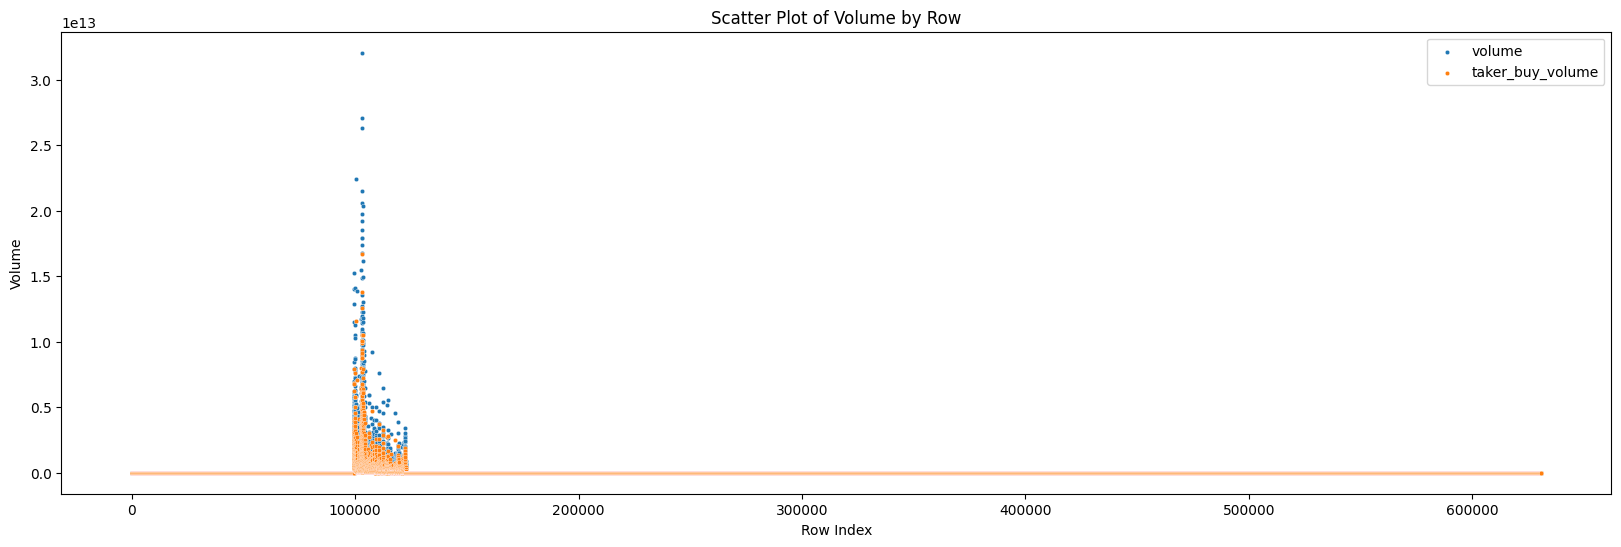

In [20]:
plot_by_id(volume_cols, 'Volume')

#### Análisis de Componentes Principales (PCA)


In [21]:
import numpy as np
from factor_analyzer import calculate_bartlett_sphericity
def bartlett_sphericity(df):
    chi_square_value, p_value = calculate_bartlett_sphericity(df)
    print(f"value={chi_square_value}")
    print(f"np-value={p_value}")
    if p_value > 0.05:
        print("NO existe correlacion entre variables")
    else:
        print("Existe correlacion entre variables")

def pca_display(pca_model):    
    explained_variance = pca_model.explained_variance_
    explained_variance_ratio = pca_model.explained_variance_ratio_
    n = len(pca_model.components_)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Número de componentes principales')
    ax1.set_ylabel('Varianza explicada', color=color)
    ax1.bar(range(1, n + 1), 
            explained_variance, alpha=0.6, color=color, label='Varianza explicada')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(range(1, n + 1))

    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Ratio de varianza explicada acumulada', color=color)
    ax2.plot(range(1, n + 1), 
             np.cumsum(explained_variance_ratio), color=color, marker='o', linestyle='dashed', linewidth=2, markersize=5, label='Ratio acumulado')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 1)
    ax2.set_xticks(range(1, n + 1))
    

    plt.title('Varianza explicada por número de componentes principales')
    fig.tight_layout()

    ax1.legend(loc='lower left')
    ax2.legend(loc='lower right')

    plt.show()


def pca_auto_components(X):
    X_std = StandardScaler().fit_transform(X)
    pca_model = PCA().fit(X_std)
    
    pca_display(pca_model)
    n_components = sum(pca_model.explained_variance_ >= 1)
    components = pca_model.transform(X_std)[:, : n_components]
    print("Ratio de varianza explicada: ", sum(pca_model.explained_variance_ratio_[: n_components]))
    return components
    

##### PCA: precio

Realizamos la prueba de esfericidad de barttlet para determinar si es óptimo aplicar PCA

In [22]:
bartlett_sphericity(df[price_cols])

value=19903317.633998383
np-value=0.0
Existe correlacion entre variables


Ejecutamos el análisis y selección de componentes principales automatizado para componentes con varianza mayor a 1.

-Conservamos únicamente un componente con una varianza explicada final de 0.9999818720925833.

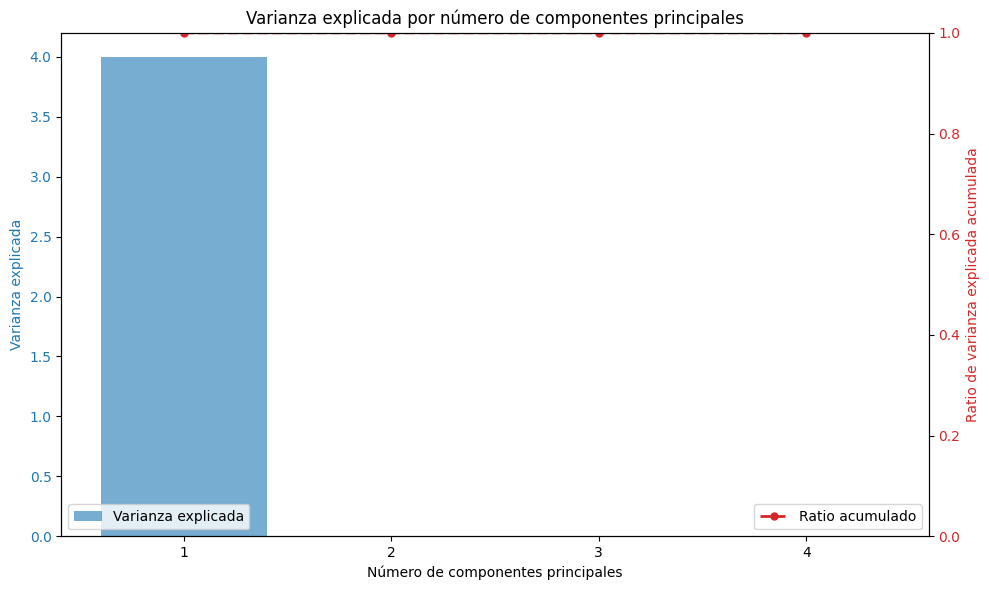

Ratio de varianza explicada:  0.9999818720925833


In [23]:
components = pca_auto_components(df[price_cols])

Agregamos la variable al dataframe 

In [24]:
df['pc_price'] = components
df.head(5)

open_time     open     high      low    close     volume  \
0  1577836800000  0.19285  0.19297  0.19219  0.19248  1339147.7   
1  1577840400000  0.19243  0.19372  0.19237  0.19371  2339976.0   
2  1577844000000  0.19371  0.19454  0.19325  0.19418  2275718.8   
3  1577847600000  0.19419  0.19427  0.19371  0.19397   972145.7   
4  1577851200000  0.19397  0.19410  0.19351  0.19363  1176061.9   

      close_time   quote_volume  count  taker_buy_volume  \
0  1577840399999  257925.439502   1278          479957.5   
1  1577843999999  452060.925165   2249         1453722.0   
2  1577847599999  441494.831939   1509         1552864.6   
3  1577851199999  188606.109345   1066          480068.8   
4  1577854799999  227937.280398   1077          770127.9   

   taker_buy_quote_volume ticker       open_datetime          close_datetime  \
0            92429.917586    XRP 2020-01-01 00:00:00 2020-01-01 00:59:59.999   
1           280854.952488    XRP 2020-01-01 01:00:00 2020-01-01 01:59:59.999   
2           301337.420868    XRP 2020-01-01 02:00:00 2020-01-01 02:59:59.999   
3            93134.098773    XRP 2020-01-01 03:00:00 2020-01-01 03:59:59.999   
4           149272.489365    XRP 2020-01-01 04:00:00 2020-01-01 04:59:59.999   

   id  mean_price  median_price  pc_price  
0   0    0.192623      0.192665 -0.460841  
1   1    0.193057      0.193070 -0.460841  
2   2    0.193920      0.193945 -0.460841  
3   3    0.194035      0.194080 -0.460841  
4   4    0.193802      0.193800 -0.460841

##### PCA: moneda de cotización

Realizamos la prueba de esfericidad de barttlet para determinar si es óptimo aplicar PCA

In [25]:
bartlett_sphericity(df[quote_cols])

value=4528294.202298501
np-value=0.0
Existe correlacion entre variables


Ejecutamos el análisis y selección de componentes principales automatizado para componentes con varianza mayor a 1

* Conservamos únicamente un componente con una varianza explicada final de 0.9617053572727392

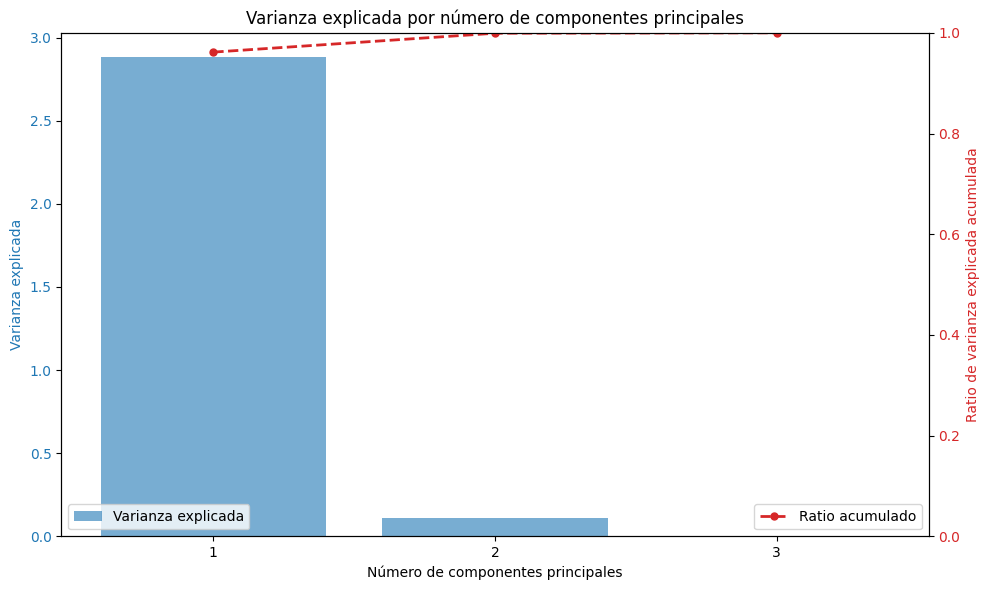

Ratio de varianza explicada:  0.9617053572727392


In [26]:
components = pca_auto_components(df[quote_cols])

* Agregamos la variable al dataframe 

In [27]:
df['pc_quote'] = components
df.head(5)

open_time     open     high      low    close     volume  \
0  1577836800000  0.19285  0.19297  0.19219  0.19248  1339147.7   
1  1577840400000  0.19243  0.19372  0.19237  0.19371  2339976.0   
2  1577844000000  0.19371  0.19454  0.19325  0.19418  2275718.8   
3  1577847600000  0.19419  0.19427  0.19371  0.19397   972145.7   
4  1577851200000  0.19397  0.19410  0.19351  0.19363  1176061.9   

      close_time   quote_volume  count  taker_buy_volume  \
0  1577840399999  257925.439502   1278          479957.5   
1  1577843999999  452060.925165   2249         1453722.0   
2  1577847599999  441494.831939   1509         1552864.6   
3  1577851199999  188606.109345   1066          480068.8   
4  1577854799999  227937.280398   1077          770127.9   

   taker_buy_quote_volume ticker       open_datetime          close_datetime  \
0            92429.917586    XRP 2020-01-01 00:00:00 2020-01-01 00:59:59.999   
1           280854.952488    XRP 2020-01-01 01:00:00 2020-01-01 01:59:59.999   
2           301337.420868    XRP 2020-01-01 02:00:00 2020-01-01 02:59:59.999   
3            93134.098773    XRP 2020-01-01 03:00:00 2020-01-01 03:59:59.999   
4           149272.489365    XRP 2020-01-01 04:00:00 2020-01-01 04:59:59.999   

   id  mean_price  median_price  pc_price  pc_quote  
0   0    0.192623      0.192665 -0.460841 -0.536331  
1   1    0.193057      0.193070 -0.460841 -0.514222  
2   2    0.193920      0.193945 -0.460841 -0.524666  
3   3    0.194035      0.194080 -0.460841 -0.540374  
4   4    0.193802      0.193800 -0.460841 -0.538127

##### PCA: volumen

In [28]:
bartlett_sphericity(df[volume_cols])

value=3385839.681587918
np-value=0.0
Existe correlacion entre variables


* Ejecutamos el análisis y selección de componentes principales automatizado para componentes con varianza mayor a 1
  
  Conservamos únicamente un componente con una varianza explicada final de 0.9617053572727392

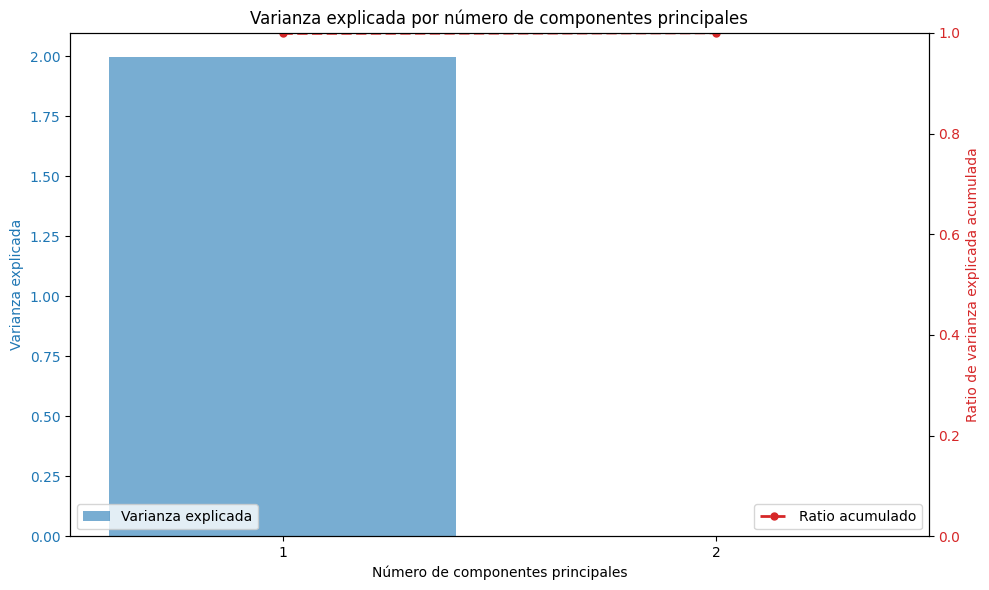

Ratio de varianza explicada:  0.9988333381591071


In [29]:
components = pca_auto_components(df[volume_cols])

* Agregamos la variable al dataframe 

In [30]:
df['pc_volume'] = components
df.head(5)

open_time     open     high      low    close     volume  \
0  1577836800000  0.19285  0.19297  0.19219  0.19248  1339147.7   
1  1577840400000  0.19243  0.19372  0.19237  0.19371  2339976.0   
2  1577844000000  0.19371  0.19454  0.19325  0.19418  2275718.8   
3  1577847600000  0.19419  0.19427  0.19371  0.19397   972145.7   
4  1577851200000  0.19397  0.19410  0.19351  0.19363  1176061.9   

      close_time   quote_volume  count  taker_buy_volume  \
0  1577840399999  257925.439502   1278          479957.5   
1  1577843999999  452060.925165   2249         1453722.0   
2  1577847599999  441494.831939   1509         1552864.6   
3  1577851199999  188606.109345   1066          480068.8   
4  1577854799999  227937.280398   1077          770127.9   

   taker_buy_quote_volume ticker       open_datetime          close_datetime  \
0            92429.917586    XRP 2020-01-01 00:00:00 2020-01-01 00:59:59.999   
1           280854.952488    XRP 2020-01-01 01:00:00 2020-01-01 01:59:59.999   
2           301337.420868    XRP 2020-01-01 02:00:00 2020-01-01 02:59:59.999   
3            93134.098773    XRP 2020-01-01 03:00:00 2020-01-01 03:59:59.999   
4           149272.489365    XRP 2020-01-01 04:00:00 2020-01-01 04:59:59.999   

   id  mean_price  median_price  pc_price  pc_quote  pc_volume  
0   0    0.192623      0.192665 -0.460841 -0.536331  -0.108086  
1   1    0.193057      0.193070 -0.460841 -0.514222  -0.108076  
2   2    0.193920      0.193945 -0.460841 -0.524666  -0.108076  
3   3    0.194035      0.194080 -0.460841 -0.540374  -0.108087  
4   4    0.193802      0.193800 -0.460841 -0.538127  -0.108085

##### Análisis del procedimiento PCA

Definimos las columnas correspondientes a los componentes

In [31]:
pc_cols = ['pc_price', 'pc_quote', 'pc_volume']

In [32]:
df[pc_cols].describe()

pc_price      pc_quote     pc_volume
count  6.306910e+05  6.306910e+05  6.306910e+05
mean   6.489273e-17  1.543005e-16 -1.045494e-17
std    1.999983e+00  1.698564e+00  1.413389e+00
min   -4.608926e-01 -5.611760e-01 -1.080934e-01
25%   -4.608364e-01 -5.243201e-01 -1.080930e-01
50%   -4.602373e-01 -4.499080e-01 -1.080902e-01
75%   -4.500083e-01 -1.904753e-01 -1.080607e-01
max    1.784699e+01  9.538734e+01  2.129937e+02

In [33]:
evalute_normal_dist(df[['pc_price', 'pc_quote', 'pc_volume']])

pc_price
  NO tiene distribución normal.
pc_quote
  NO tiene distribución normal.
pc_volume
  NO tiene distribución normal.


c:\Users\Cesar\Documents\GitHub\ML-TF\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 630691.
  res = hypotest_fun_out(*samples, **kwds)


Podemos observar un comportamiento basico de mercado, precios altos reducen la volumen de ventas

<Axes: >

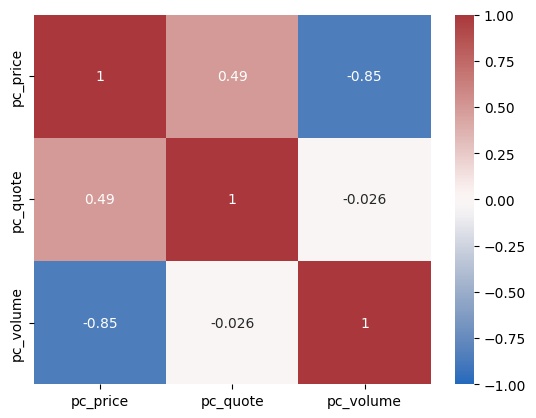

In [34]:
sns.heatmap(df[pc_cols].corr(method='spearman'), annot=True, cmap='vlag', vmin=-1, vmax=1)

# Series temporales

## Visualización

In [35]:
df.head()

open_time     open     high      low    close     volume  \
0  1577836800000  0.19285  0.19297  0.19219  0.19248  1339147.7   
1  1577840400000  0.19243  0.19372  0.19237  0.19371  2339976.0   
2  1577844000000  0.19371  0.19454  0.19325  0.19418  2275718.8   
3  1577847600000  0.19419  0.19427  0.19371  0.19397   972145.7   
4  1577851200000  0.19397  0.19410  0.19351  0.19363  1176061.9   

      close_time   quote_volume  count  taker_buy_volume  \
0  1577840399999  257925.439502   1278          479957.5   
1  1577843999999  452060.925165   2249         1453722.0   
2  1577847599999  441494.831939   1509         1552864.6   
3  1577851199999  188606.109345   1066          480068.8   
4  1577854799999  227937.280398   1077          770127.9   

   taker_buy_quote_volume ticker       open_datetime          close_datetime  \
0            92429.917586    XRP 2020-01-01 00:00:00 2020-01-01 00:59:59.999   
1           280854.952488    XRP 2020-01-01 01:00:00 2020-01-01 01:59:59.999   
2           301337.420868    XRP 2020-01-01 02:00:00 2020-01-01 02:59:59.999   
3            93134.098773    XRP 2020-01-01 03:00:00 2020-01-01 03:59:59.999   
4           149272.489365    XRP 2020-01-01 04:00:00 2020-01-01 04:59:59.999   

   id  mean_price  median_price  pc_price  pc_quote  pc_volume  
0   0    0.192623      0.192665 -0.460841 -0.536331  -0.108086  
1   1    0.193057      0.193070 -0.460841 -0.514222  -0.108076  
2   2    0.193920      0.193945 -0.460841 -0.524666  -0.108076  
3   3    0.194035      0.194080 -0.460841 -0.540374  -0.108087  
4   4    0.193802      0.193800 -0.460841 -0.538127  -0.108085

In [36]:
def timeline_per_ticker(df):
    tickers = df['ticker'].unique().tolist()
    fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(20, 6*len(tickers)))

    for i, ticker in enumerate(tickers):
        df_ticker = df[df['ticker'] == ticker]
        df_ticker.sort_values('open_datetime')
        axes[i].plot(
            df_ticker['open_datetime'], df_ticker['open'], 
            alpha=0.1, color='black', label='open', linewidth=0.5)
        axes[i].plot(
            df_ticker['open_datetime'], df_ticker['median_price'], 
            alpha=0.1, color='blue', label='median_price', linewidth=0.5)
        axes[i].plot(
            df_ticker['open_datetime'], df_ticker['mean_price'], 
            alpha=0.1, color='red', label='mean_price', linewidth=0.5)
        
        axes[i].set_title(f'Evolución de {ticker}')
        axes[i].set_xlabel('Tiempo')
        axes[i].set_ylabel('Valores')
        axes[i].set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2023-12-31'))  # Establecer la fecha de inicio y final del eje y
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

def axe_timeserie_plot(df_timeseries: pd.DataFrame):
    n = df_timeseries.shape[1]
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(10, 4*n))
    for i, col in enumerate(df_timeseries.columns):
        axes[i].plot(
            df_timeseries.index, df_timeseries[col], 
            color='blue', label='Target', linewidth=0.5)
        axes[i].set_xlim(df_timeseries.index[0], df_timeseries.index[-1])  # Establecer la fecha de inicio y final del eje y
        axes[i].set_title(col)
        axes[i].grid(True)
    plt.show()


def timeserie_plot(df):
    plt.figure(figsize=(10,  5))

    plt.plot(
        df.index, df['target'], 
        color='blue', label='Target', linewidth=0.5
        )
    plt.xlabel('Tiempo')
    plt.ylabel('Valores')
    plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2023-12-31'))  # Establecer la fecha de inicio y final del eje y
    plt.legend()
    plt.grid(True)
    plt.show()

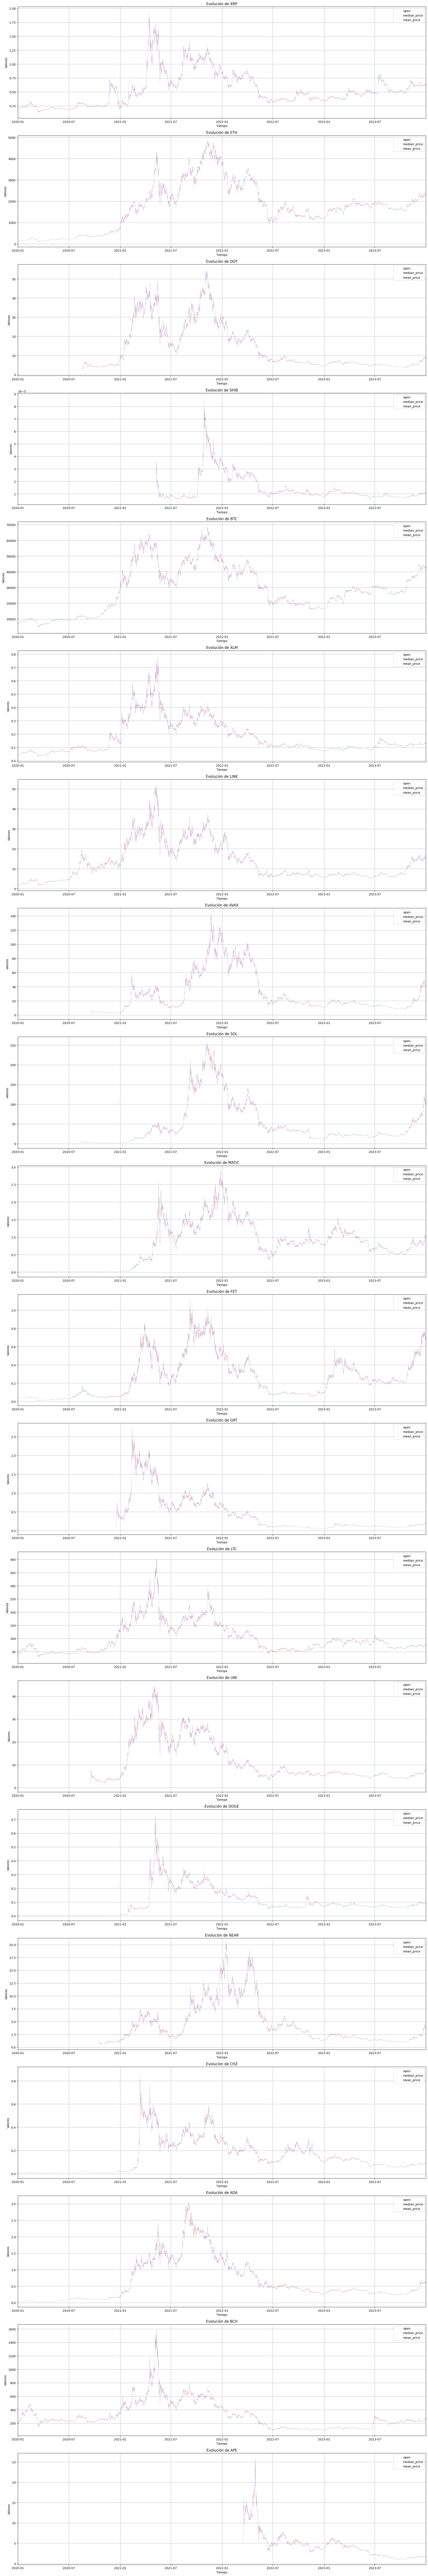

In [37]:
timeline_per_ticker(df)

## Transformacion de los datos

Para las series de tiempo utilizaremos como referencia la fecha de apertura del intervalo y el componente de precio

In [38]:
#df_selected = df[['ticker', 'open_datetime', 'median_price']]

# Procesamiento de datos

In [39]:
def timeserie_preprocessing(df, ticker, time_col, target_col, mean_window=24):
    df_target = df.loc[df['ticker'] == ticker, [time_col, target_col]]
    df_target.columns = ['timestamp', 'target']
    df_target.sort_values('timestamp')
    df_target = df_target.set_index('timestamp')
    df_target = df_target.asfreq('h')

    if df_target.isna().sum()['target'] > 0:
        df_target['target_mean'] = df_target['target'].rolling(window=mean_window, min_periods=1).mean()
        df_target['target'] = df_target['target'].combine_first(df_target['target_mean'])
        df_target = df_target.drop('target_mean', axis=1)
        
    print(ticker, "missing values", df_target.isna().sum())
    return df_target

Creamos un diccionario con las series de tiempo de cada criptomoneda revisando que la serie no tenga intervalos intermedios faltantes y los más importante un formato de indice óptimo

In [40]:
timeseries = {}
for ticker in df['ticker'].unique():
    timeseries[ticker] = timeserie_preprocessing(df, ticker, "open_datetime", "median_price")

XRP missing values target    0
dtype: int64
ETH missing values target    0
dtype: int64
DOT missing values target    0
dtype: int64
SHIB missing values target    0
dtype: int64
BTC missing values target    0
dtype: int64
XLM missing values target    0
dtype: int64
LINK missing values target    0
dtype: int64
AVAX missing values target    0
dtype: int64
SOL missing values target    0
dtype: int64
MATIC missing values target    0
dtype: int64
FET missing values target    0
dtype: int64
GRT missing values target    0
dtype: int64
LTC missing values target    0
dtype: int64
UNI missing values target    0
dtype: int64
DOGE missing values target    0
dtype: int64
NEAR missing values target    0
dtype: int64
CHZ missing values target    0
dtype: int64
ADA missing values target    0
dtype: int64
BCH missing values target    0
dtype: int64
APE missing values target    0
dtype: int64


Usamos las series de tiempo para formar un nuevo dataframe con las series de tiempo como columnas para que sean comparables

In [41]:
df_timeseries = pd.concat(timeseries.values(), axis = 1)
df_timeseries.columns = timeseries.keys()

In [42]:
df_timeseries.head(5)

XRP      ETH  DOT  SHIB       BTC       XLM  \
timestamp                                                               
2020-01-01 00:00:00  0.192665  129.015  NaN   NaN  7186.130  0.044915   
2020-01-01 01:00:00  0.193070  129.755  NaN   NaN  7196.370  0.045025   
2020-01-01 02:00:00  0.193945  130.740  NaN   NaN  7229.185  0.045220   
2020-01-01 03:00:00  0.194080  130.525  NaN   NaN  7233.835  0.045220   
2020-01-01 04:00:00  0.193800  130.205  NaN   NaN  7221.135  0.045150   

                        LINK  AVAX  SOL     MATIC       FET  GRT     LTC  UNI  \
timestamp                                                                       
2020-01-01 00:00:00  1.76580   NaN  NaN  0.013815  0.037170  NaN  41.285  NaN   
2020-01-01 01:00:00  1.77350   NaN  NaN  0.013865  0.037570  NaN  41.450  NaN   
2020-01-01 02:00:00  1.79285   NaN  NaN  0.013945  0.037885  NaN  41.740  NaN   
2020-01-01 03:00:00  1.79695   NaN  NaN  0.013930  0.037945  NaN  41.685  NaN   
2020-01-01 04:00:00  1.79540   NaN  NaN  0.013910  0.037955  NaN  41.560  NaN   

                         DOGE  NEAR       CHZ       ADA      BCH  APE  
timestamp                                                              
2020-01-01 00:00:00  0.002011   NaN  0.007045  0.032815  204.500  NaN  
2020-01-01 01:00:00  0.002015   NaN  0.007090  0.032880  205.325  NaN  
2020-01-01 02:00:00  0.002025   NaN  0.007115  0.033080  206.815  NaN  
2020-01-01 03:00:00  0.002017   NaN  0.007157  0.033110  206.520  NaN  
2020-01-01 04:00:00  0.002017   NaN  0.007174  0.033000  205.955  NaN

A causa de la transformación tenemos nuevos datos faltantes los cuales trataremos más adelante. Tienes que deshacerte de las criptomonedas con más del 15% de datos faltantes

In [43]:
missings = df_timeseries.isna().sum()/df_timeseries.shape[0]*100
missings 

XRP       0.000000
ETH       0.000000
DOT      15.808236
SHIB     33.912275
BTC       0.000000
XLM       0.000000
LINK      0.000000
AVAX     18.155373
SOL      15.280630
MATIC     0.000000
FET       0.000000
GRT      24.081679
LTC       0.000000
UNI      17.804586
DOGE      0.000000
NEAR     19.658339
CHZ       0.000000
ADA       0.000000
BCH       0.000000
APE      55.207620
dtype: float64

In [44]:
df_timeseries_missings = df_timeseries
df_timeseries = df_timeseries[df_timeseries.columns[missings < 15]]

In [45]:
df_timeseries.isna().sum()/df_timeseries.shape[0]*100

XRP      0.0
ETH      0.0
BTC      0.0
XLM      0.0
LINK     0.0
MATIC    0.0
FET      0.0
LTC      0.0
DOGE     0.0
CHZ      0.0
ADA      0.0
BCH      0.0
dtype: float64

In [46]:
df_timeseries

XRP       ETH        BTC       XLM      LINK  \
timestamp                                                                
2020-01-01 00:00:00  0.192665   129.015   7186.130  0.044915   1.76580   
2020-01-01 01:00:00  0.193070   129.755   7196.370  0.045025   1.77350   
2020-01-01 02:00:00  0.193945   130.740   7229.185  0.045220   1.79285   
2020-01-01 03:00:00  0.194080   130.525   7233.835  0.045220   1.79695   
2020-01-01 04:00:00  0.193800   130.205   7221.135  0.045150   1.79540   
...                       ...       ...        ...       ...       ...   
2023-12-31 19:00:00  0.620800  2299.015  42637.865  0.129750  15.29650   
2023-12-31 20:00:00  0.619500  2288.615  42588.525  0.129300  15.20250   
2023-12-31 21:00:00  0.618850  2282.800  42539.370  0.129300  15.13200   
2023-12-31 22:00:00  0.615300  2278.990  42389.305  0.128900  15.02650   
2023-12-31 23:00:00  0.613500  2278.315  42270.735  0.128650  14.92150   

                        MATIC       FET     LTC      DOGE       CHZ       ADA  \
timestamp                                                                       
2020-01-01 00:00:00  0.013815  0.037170  41.285  0.002011  0.007045  0.032815   
2020-01-01 01:00:00  0.013865  0.037570  41.450  0.002015  0.007090  0.032880   
2020-01-01 02:00:00  0.013945  0.037885  41.740  0.002025  0.007115  0.033080   
2020-01-01 03:00:00  0.013930  0.037945  41.685  0.002017  0.007157  0.033110   
2020-01-01 04:00:00  0.013910  0.037955  41.560  0.002017  0.007174  0.033000   
...                       ...       ...     ...       ...       ...       ...   
2023-12-31 19:00:00  1.006550  0.692450  73.955  0.090405  0.088310  0.600450   
2023-12-31 20:00:00  0.995450  0.688300  73.770  0.089970  0.087825  0.599500   
2023-12-31 21:00:00  0.986250  0.688450  73.715  0.089750  0.087585  0.600550   
2023-12-31 22:00:00  0.976900  0.680500  73.115  0.089505  0.086870  0.595450   
2023-12-31 23:00:00  0.968700  0.670750  72.635  0.089350  0.086150  0.591550   

                         BCH  
timestamp                     
2020-01-01 00:00:00  204.500  
2020-01-01 01:00:00  205.325  
2020-01-01 02:00:00  206.815  
2020-01-01 03:00:00  206.520  
2020-01-01 04:00:00  205.955  
...                      ...  
2023-12-31 19:00:00  262.300  
2023-12-31 20:00:00  261.000  
2023-12-31 21:00:00  260.900  
2023-12-31 22:00:00  258.650  
2023-12-31 23:00:00  257.900  

[35064 rows x 12 columns]

In [47]:
df_timeseries.index

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=35064, freq='h')

In [48]:
df_timeseries.to_csv('dataset/timeseries.csv', sep=';')

## Análisis de datos transformados

Las series de tiempo del precio de las cryptomonedas siguen sin tener una distribución normal

In [49]:
evalute_normal_dist(df_timeseries)

XRP
  NO tiene distribución normal.
ETH
  NO tiene distribución normal.
BTC
  NO tiene distribución normal.
XLM
  NO tiene distribución normal.
LINK
  NO tiene distribución normal.
MATIC
  NO tiene distribución normal.
FET
  NO tiene distribución normal.
LTC
  NO tiene distribución normal.
DOGE
  NO tiene distribución normal.
CHZ
  NO tiene distribución normal.
ADA
  NO tiene distribución normal.
BCH
  NO tiene distribución normal.


c:\Users\Cesar\Documents\GitHub\ML-TF\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 35064.
  res = hypotest_fun_out(*samples, **kwds)


La correlacion observada para la criptomoneda BCH es visiblemente anormal

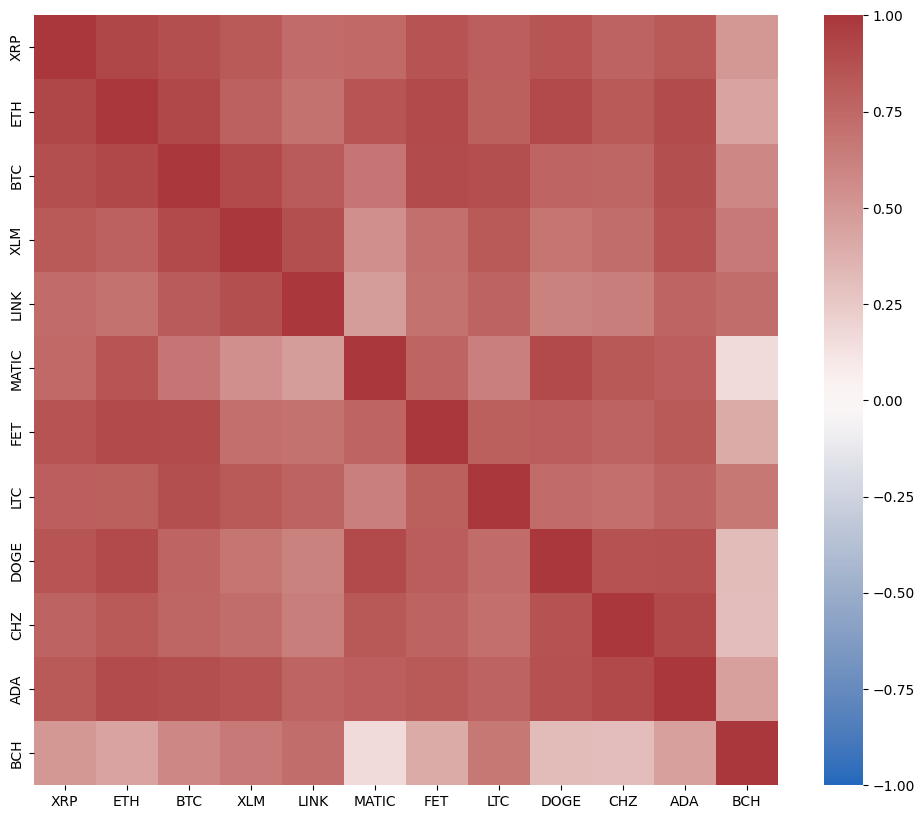

In [50]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_timeseries.corr(method='spearman'), cmap='vlag', vmin=-1, vmax=1)
plt.show()

## Test

Utilizando un dendograma podemos verificar el comportamiento anormal

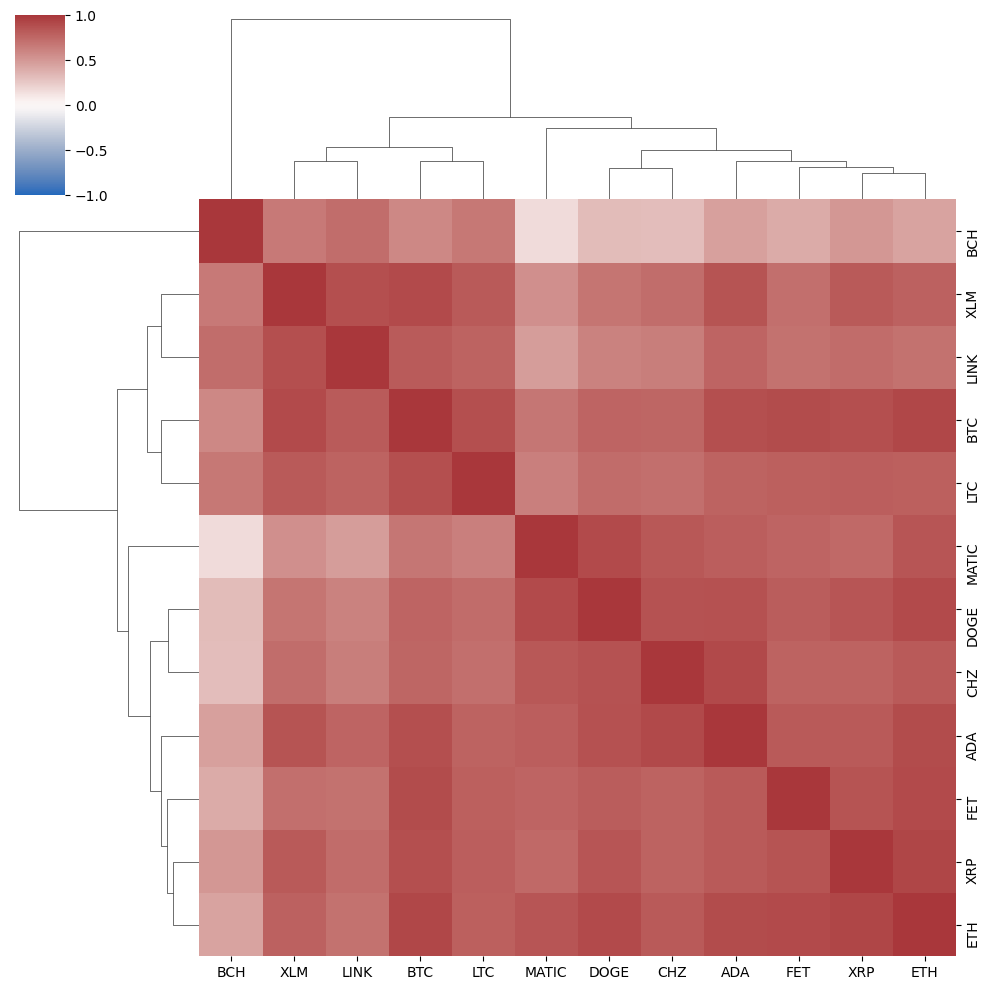

In [52]:
sns.clustermap(df_timeseries.corr(method='spearman'), cmap='vlag', vmin=-1, vmax=1)

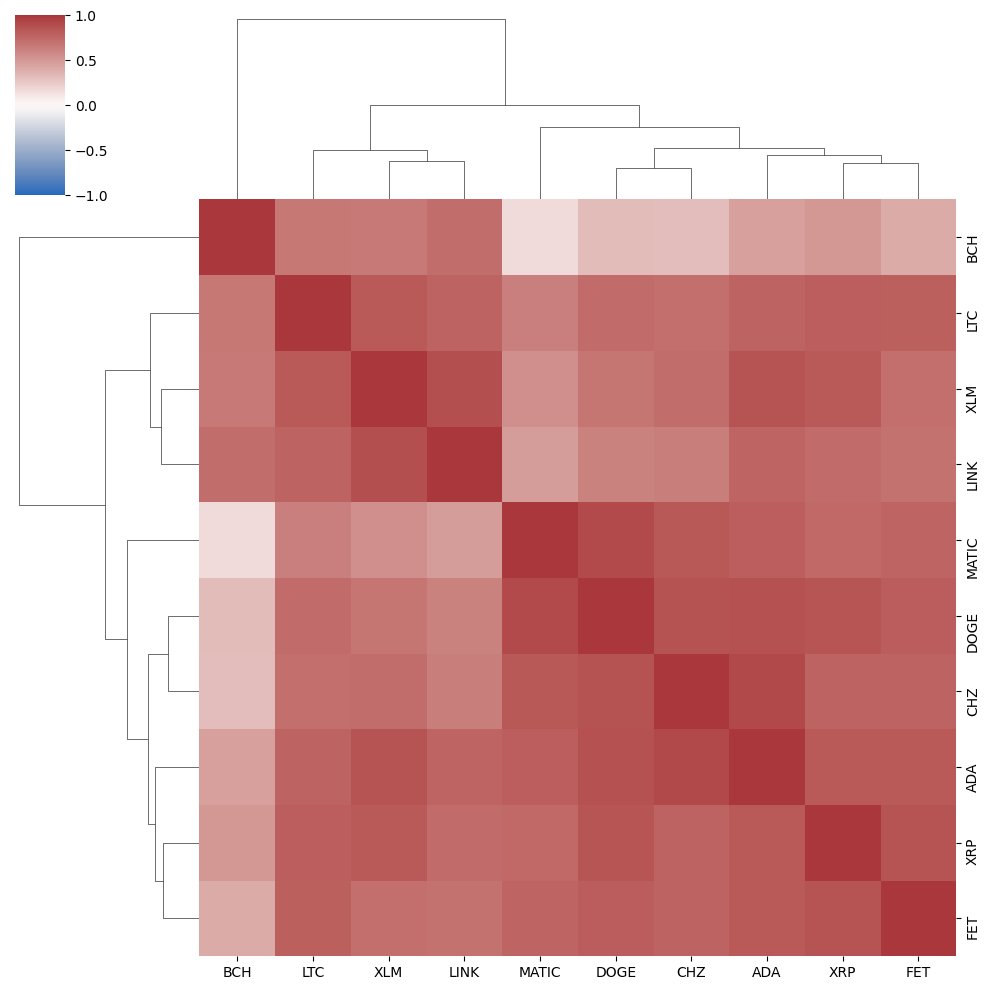

In [53]:
sns.clustermap(
    df_timeseries.drop(['BTC', 'ETH'], axis=1).corr(method='spearman'),
    cmap='vlag', 
    vmin=-1, vmax=1)

[[['FET', 'XRP'], 'ADA'], ['CHZ', 'DOGE'], 'MATIC']

[['FET', 'XRP'], 'ADA'], ['CHZ', 'DOGE'], 'MATIC'

['FET', 'XRP'], 'ADA', ['CHZ', 'DOGE'], 'MATIC'

TEST DE CORRELACION

In [73]:
evalute_corr(df_timeseries, 0.80)

Correlación
XRP | ETH
  corr=0.923984
XRP | BTC
  corr=0.880959
XRP | XLM
  corr=0.826062
XRP | FET
  corr=0.851623
XRP | LTC
  corr=0.804275
XRP | DOGE
  corr=0.848784
XRP | ADA
  corr=0.827734
ETH | BTC
  corr=0.918737
ETH | MATIC
  corr=0.848607
ETH | FET
  corr=0.902892
ETH | DOGE
  corr=0.900954
ETH | CHZ
  corr=0.825356
ETH | ADA
  corr=0.8927
BTC | XLM
  corr=0.89912
BTC | LINK
  corr=0.81344
BTC | FET
  corr=0.896023
BTC | LTC
  corr=0.882218
BTC | ADA
  corr=0.87904
XLM | LINK
  corr=0.8751
XLM | LTC
  corr=0.824593
XLM | ADA
  corr=0.85773
MATIC | DOGE
  corr=0.899779
MATIC | CHZ
  corr=0.832342
MATIC | ADA
  corr=0.803684
FET | DOGE
  corr=0.80586
FET | ADA
  corr=0.823427
DOGE | CHZ
  corr=0.863243
DOGE | ADA
  corr=0.87201
CHZ | ADA
  corr=0.912129


In [63]:
group_A = ['FET', 'XRP']
group_B = ['ADA']
group_C = ['CHZ', 'DOGE']
group_D = ['MATIC']

In [96]:
evalute_corr(df_timeseries[group_A + ['BTC', 'ETH']], 0.80)

Correlación
XRP | ETH
  corr=0.923984
BTC | ETH
  corr=0.918737
FET | ETH
  corr=0.902892
FET | BTC
  corr=0.896023
XRP | BTC
  corr=0.880959
FET | XRP
  corr=0.851623


In [97]:
evalute_corr(df_timeseries[group_B + ['BTC', 'ETH']], 0.80)

Correlación
BTC | ETH
  corr=0.918737
ADA | ETH
  corr=0.8927
ADA | BTC
  corr=0.87904


In [98]:
evalute_corr(df_timeseries[group_C + ['BTC', 'ETH']], 0.80)

Correlación
BTC | ETH
  corr=0.918737
DOGE | ETH
  corr=0.900954
CHZ | DOGE
  corr=0.863243
CHZ | ETH
  corr=0.825356


In [100]:
evalute_corr(df_timeseries[group_D + ['BTC', 'ETH']], 0.80)

Correlación
BTC | ETH
  corr=0.918737
MATIC | ETH
  corr=0.848607


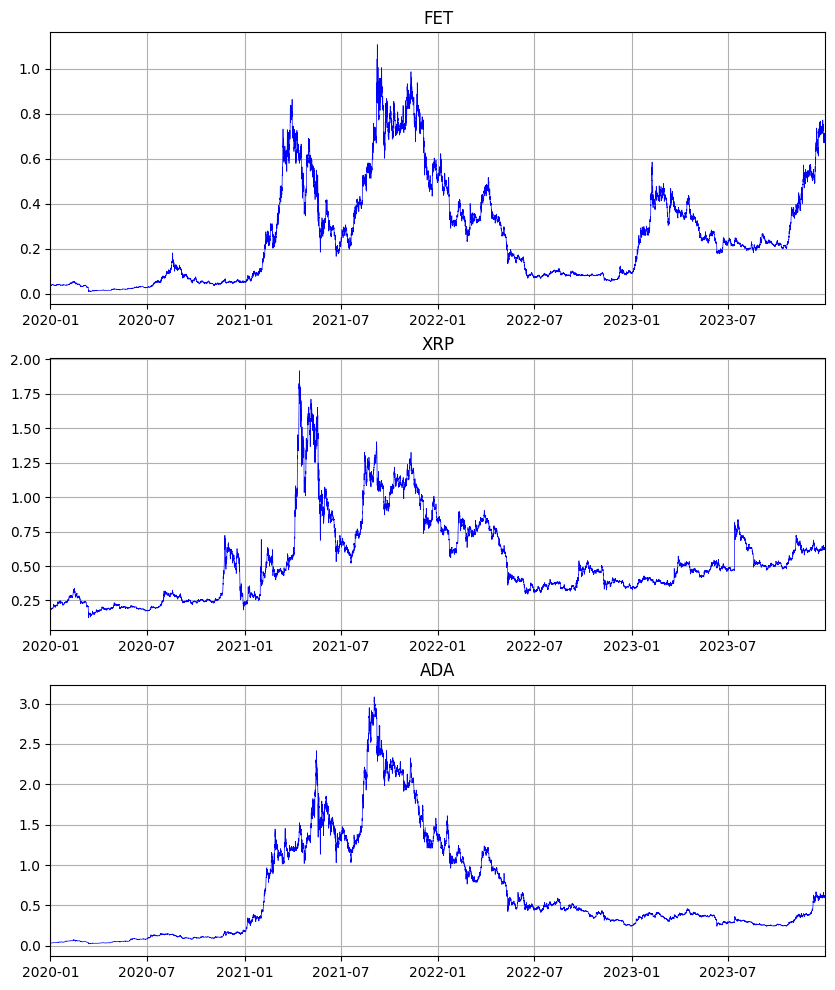

In [80]:
axe_timeserie_plot(df_timeseries[group_A + group_B])

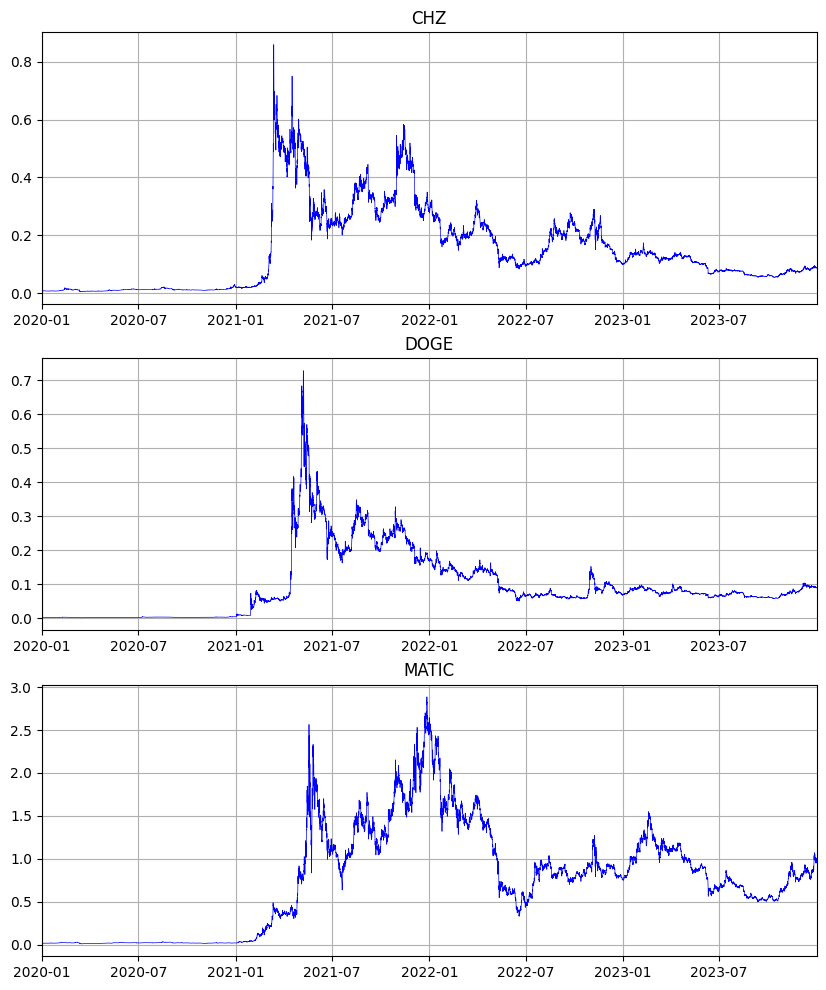

In [81]:
axe_timeserie_plot(df_timeseries[group_C + group_D])

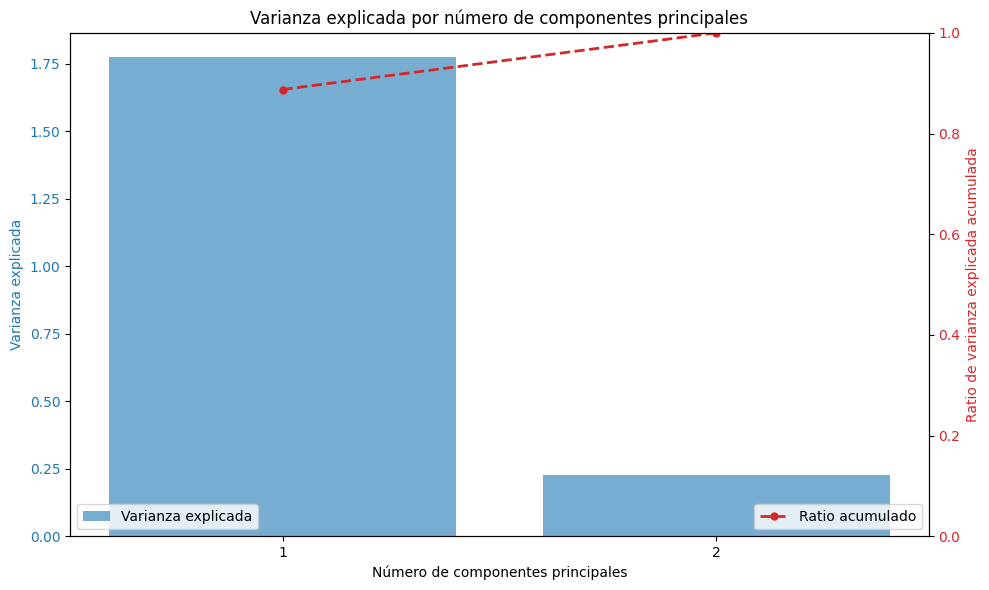

Ratio de varianza explicada:  0.887395020212757


In [149]:
df_timeseries['temp'] = pca_auto_components(my_timeseries[crypto_type_C])

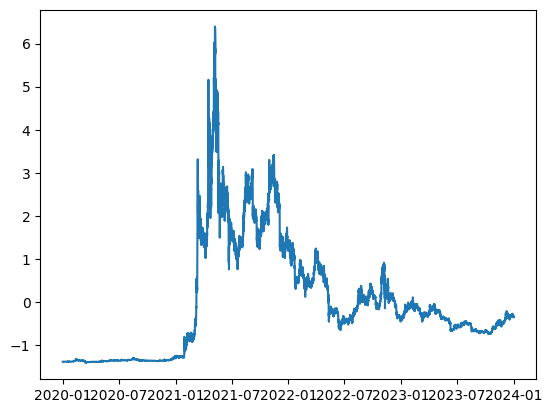

In [151]:
plt.plot(df_timeseries.index, df_timeseries['temp'])

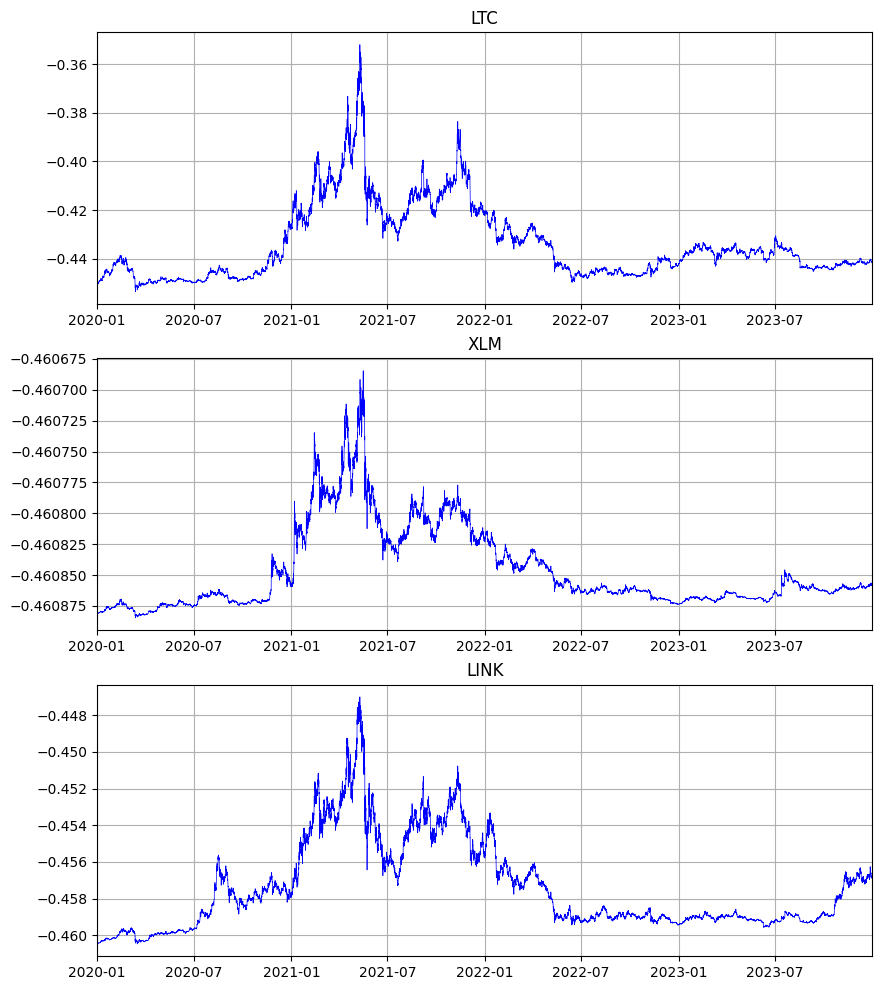

In [147]:
axe_timeserie_plot(my_timeseries[crypto_type_D])

In [ ]:
pca_auto_components(my_timeseries[crypto_type_D])

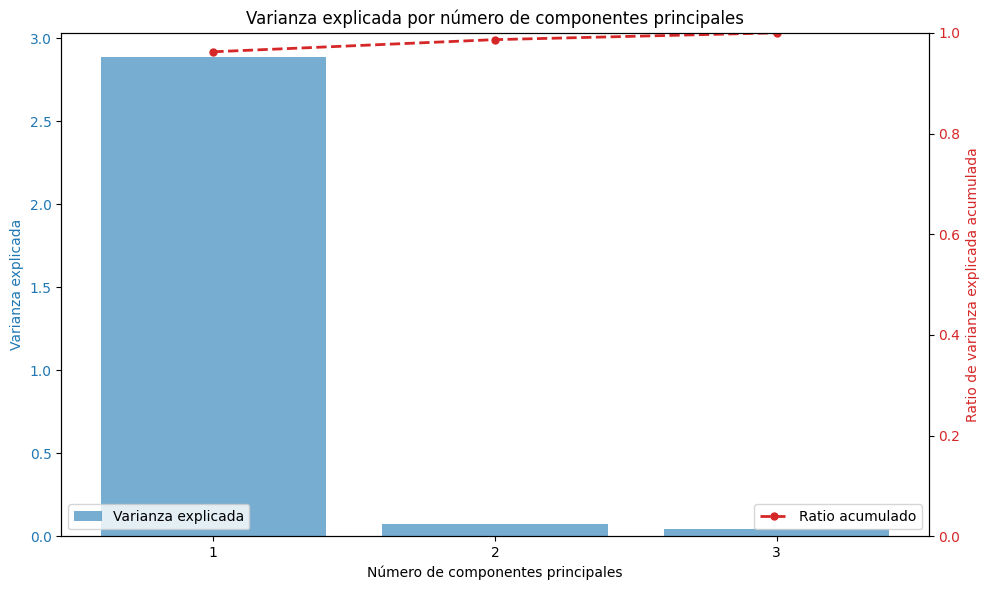

Ratio de varianza explicada:  0.9623628960652489


array([[-1.87550941],
       [-1.8722959 ],
       [-1.86767234],
       ...,
       [-0.3438131 ],
       [-0.36627533],
       [-0.37261061]])

In [148]:
pca_auto_components(my_timeseries[crypto_type_D])

GRUPO A

* Prueba de esfericidad

In [ ]:
bartlett_sphericity(my_timeseries[crypto_type_A])
print("Tienen correlacion")

value=135636.80457161777
np-value=0.0
Existe correlacion entre variables
Tienen correlacion


In [ ]:
def pca_auto_components(df):
    X_scaled = StandardScaler().fit_transform(df)
    pca_model = PCA().fit(X_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_

    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center')
    plt.plot(range(1, len(explained_variance_ratio) + 1), 
             np.cumsum(explained_variance_ratio))#, where='mid')
    plt.xlabel('Número de componentes principales')
    plt.ylabel('Ratio de varianza explicada')
    plt.title('Varianza explicada por número de componentes principales')
    plt.show()
    return pca_model

In [ ]:
pca_auto_components(my_timeseries[crypto_type_A])

NameError: name 'pca' is not defined

In [ ]:
df_timeseries.index[-1]

Timestamp('2023-12-31 23:00:00')

In [ ]:
bartlett_sphericity(my_timeseries[['XRP', 'FET', 'DOGE', 'CHZ', 'SOL', 'MATIC']])

value=136019.8276451307
np-value=0.0


In [ ]:
#Correlacion entre series de tiempo
def timeseries_corr(df_timeseries:pd.DataFrame):
    for ticker1, ticker2 in combinations(df_timeseries.columns, 2):
        temp = df_timeseries[[ticker1, ticker2]].dropna()
        corr = temp[ticker1].corr(temp[ticker2])
        if corr > 0.8:
            print(ticker1, ticker2)
            print("Correlacion: ", corr)

timeseries_corr(df_timeseries)

XRP ETH
Correlacion:  0.855994764042231
XRP BTC
Correlacion:  0.8441988986290343
XRP XLM
Correlacion:  0.8080307006985077
XRP LINK
Correlacion:  0.8079380112996822
XRP LTC
Correlacion:  0.8306869972163646
XRP DOGE
Correlacion:  0.8719367435836235
XRP ADA
Correlacion:  0.8543681524784488
ETH BTC
Correlacion:  0.8901255138749313
ETH AVAX
Correlacion:  0.8251999911501754
ETH SOL
Correlacion:  0.8743616518968661
ETH MATIC
Correlacion:  0.876372617534491
ETH FET
Correlacion:  0.8416159298359015
ETH DOGE
Correlacion:  0.8006683908116461
ETH ADA
Correlacion:  0.8418935620736657
DOT BTC
Correlacion:  0.8895661143308287
DOT XLM
Correlacion:  0.8992610823378379
DOT LINK
Correlacion:  0.9048054546403381
DOT GRT
Correlacion:  0.8680650544260962
DOT LTC
Correlacion:  0.9002384358967824
DOT UNI
Correlacion:  0.9036804479042609
DOT CHZ
Correlacion:  0.8082982976109718
DOT ADA
Correlacion:  0.8631575611421711
DOT BCH
Correlacion:  0.833792258792217
DOT APE
Correlacion:  0.8800563799584344
SHIB AVAX
Co

In [ ]:
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
from scipy.stats import ttest_ind
from dtaidistance import dtw

In [ ]:
#Correlacion entre series de tiempo
# Cointegración
def timeseries_corr(df_timeseries:pd.DataFrame):
    for ticker1, ticker2 in combinations(df_timeseries.columns, 2):
        temp = df[[ticker1, ticker2]].dropna()
        corr = temp[ticker1].corr(temp[ticker2])
        score, p_value, _ = coint(df1['value'], df2['value'])
        if corr > 0.8:
            print(ticker1, ticker2)
            print("Correlacion: ", corr)


print(f'P-valor de cointegración: {p_value}')

# Dynamic Time Warping (DTW)
series1 = np.array(df1['value'])
series2 = np.array(df2['value'])
distance = dtw.distance(series1, series2)
print(f'Distancia DTW: {distance}')

# Prueba de Hipótesis
t_stat, p_value = ttest_ind(df1['value'], df2['value'])
print(f'T-statistic: {t_stat}, P-value: {p_value}')

1. Prueba de estacionariedad

In [ ]:
# Ho serie de tiempo no estacionaria
# Ha serie de tiempo estacionaria
for ticker in timeseries:
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(timeseries[ticker])
    print("--------------------------------------")
    print(ticker)
    print(f"ADF Statistic (original): {result[0]}")
    print(f"p-value (original): {result[1]}")
    if result[1] > 0.05:
        print("NO estacionaria")
    else:
        print("Estacionaria")

--------------------------------------
XRP
ADF Statistic (original): -2.6244813516801004
p-value (original): 0.08804228985997686
NO estacionaria
--------------------------------------
ETH
ADF Statistic (original): -1.7765804558691507
p-value (original): 0.3921492591331313
NO estacionaria
--------------------------------------
DOT
ADF Statistic (original): -1.793524245780767
p-value (original): 0.38368143244528
NO estacionaria
--------------------------------------
SHIB
ADF Statistic (original): -2.4718584932135497
p-value (original): 0.1224724469286535
NO estacionaria
--------------------------------------
BTC
ADF Statistic (original): -1.6341200109464997
p-value (original): 0.46533488005884627
NO estacionaria
--------------------------------------
XLM
ADF Statistic (original): -2.1103111122217717
p-value (original): 0.24038871619453162
NO estacionaria
--------------------------------------
LINK
ADF Statistic (original): -2.225846160124198
p-value (original): 0.19699886426416385
NO est

2. Funciones de Autocorrelación (ACF) y Autocorrelación Parcial (PACF)

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def autocorr_and_partialautocorr(timeseries):
    n = len(timeseries)
    lags = 200
    fig, axes = plt.subplots(n, 2, figsize=(32, 4*n))
    for i, ticker in enumerate(timeseries):
        plot_acf(timeseries[ticker], ax=axes[i, 0], lags=lags)
        plot_pacf(timeseries[ticker], ax=axes[i, 1], lags=lags)
    plt.show()

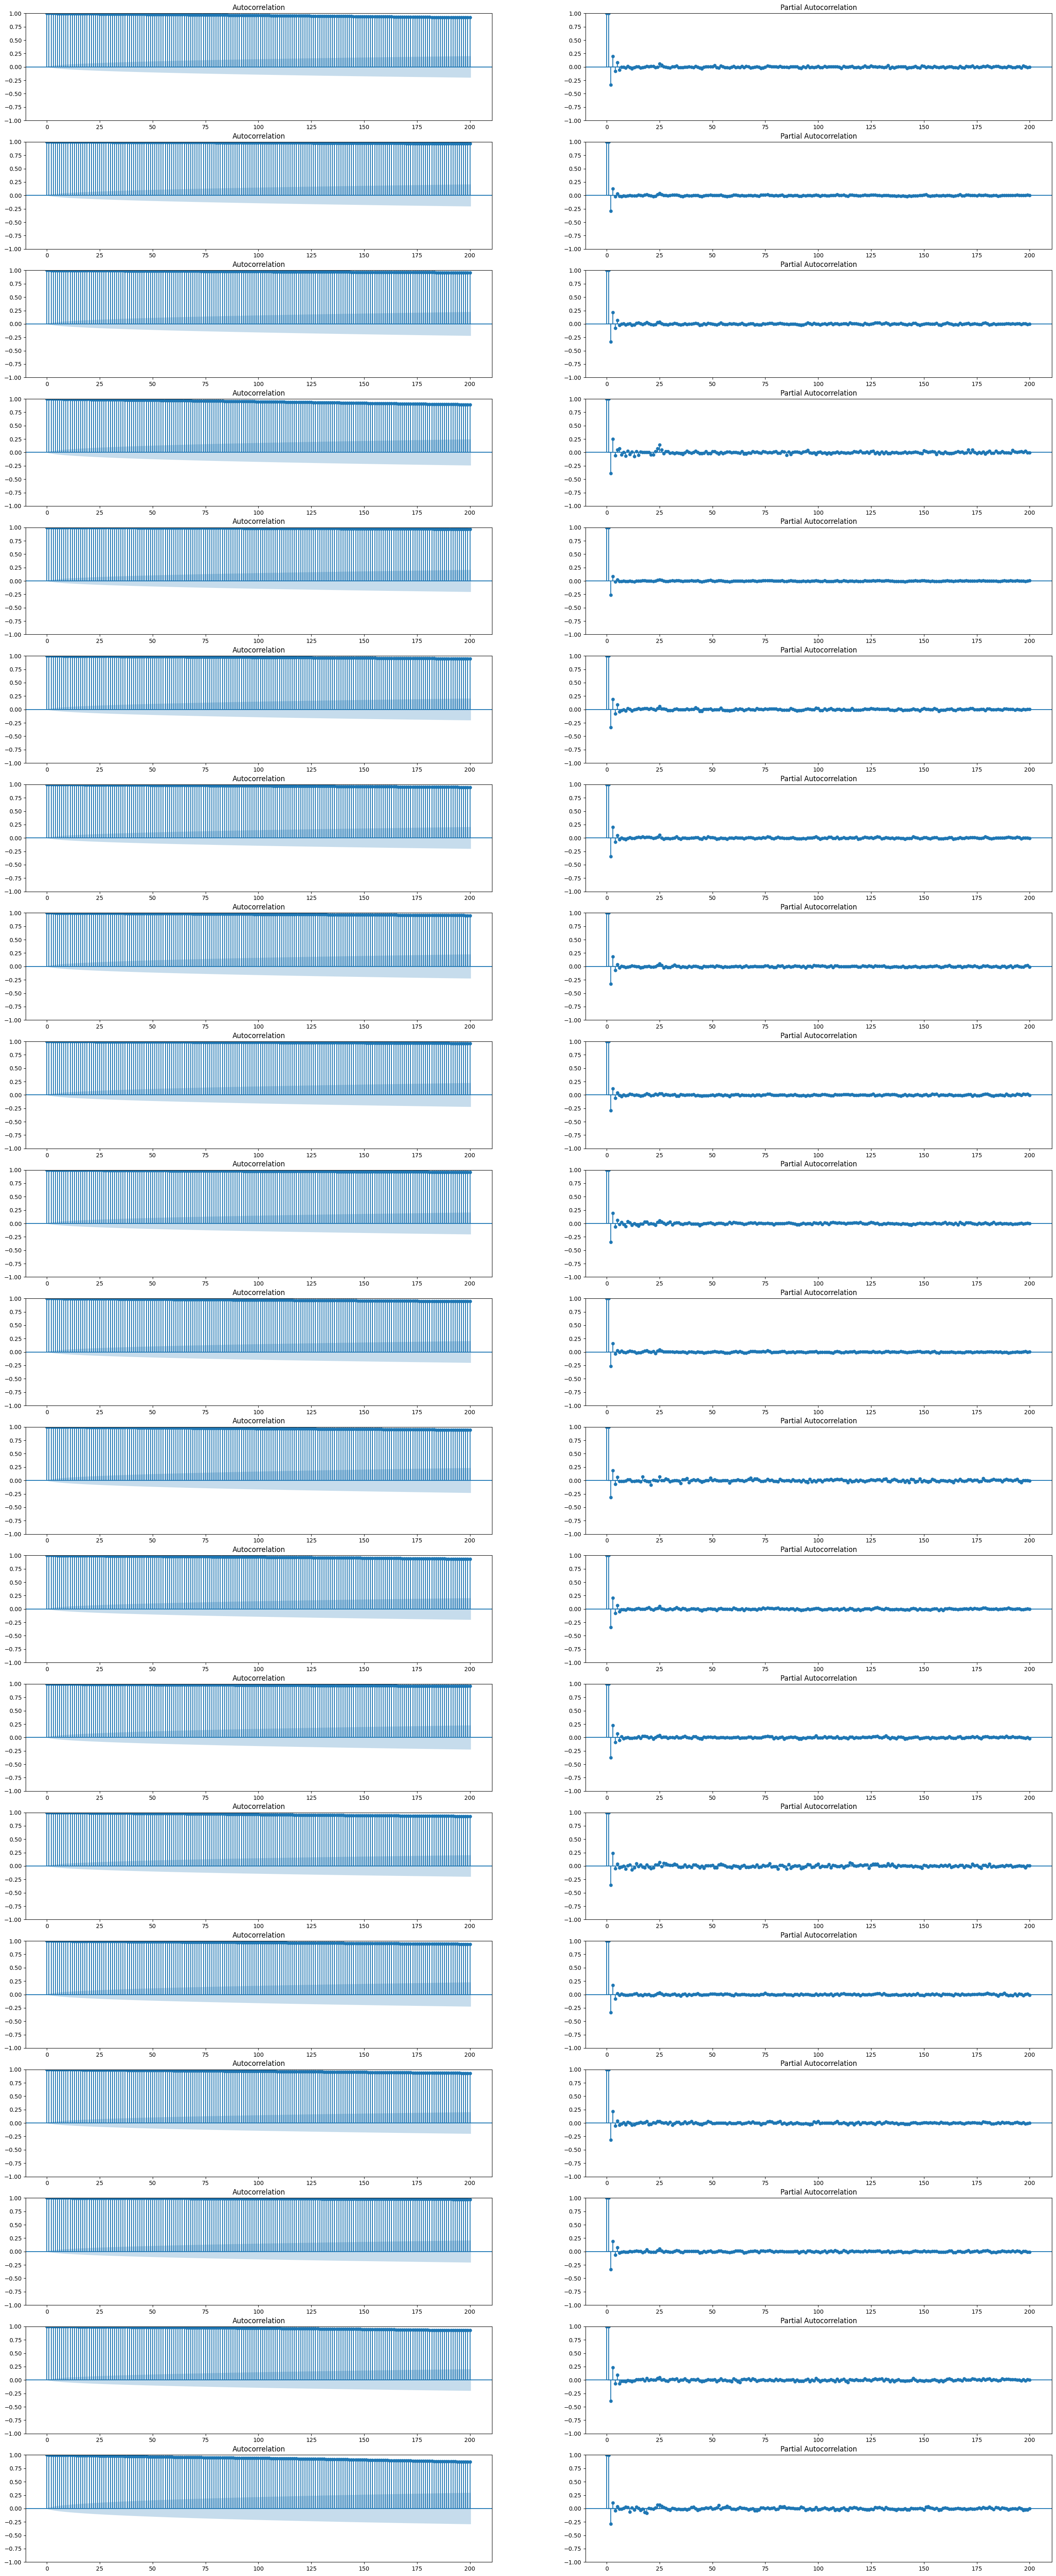

In [ ]:
autocorr_and_partialautocorr(timeseries)

Se requiere arima como modelo estadistico

La ACF ayuda a identificar cuántos retardos anteriores influyen en los valores actuales.
La PACF ayuda a identificar el número de términos autoregresivos necesarios en un modelo ARIMA eliminando la influencia de los términos intermedios.

3. Descomposición de la Serie de Tiempo

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomponer la serie de tiempo
#series_log = np.log(series)
def log_timeserie(df_timeserie):
    return np.log(df_timeserie)


def diff_timeserie(df_timeserie):
    df_timeserie_diff = df_timeserie.diff().dropna()
    return df_timeserie_diff

def seasonal_decompose(df_timeserie, period=3000):
    # plt.figure(figsize=(16, 4))
    result = seasonal_decompose(
        df_timeserie, 
        model='additive', 
        period=6000) #3000
    result.plot()
    plt.show()

In [ ]:
def train_arima(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12)):
    model = ARIMA(train['target'], order=order, seasonal_order=seasonal_order).fit()
    return model

## Modelado

In [ ]:
def timeserie_train_test_split(df, size):
    div = round(df.shape[0] * size)
    train = df.iloc[:div]
    test = df.iloc[div:]
    return train, test

def arima_preprocessing(df, tickers):
    models = dict()
    df[['ticker', 'open_datetime', 'PC_price']]
    for ticker in tickers:
        df_ticker = df[df['ticker'] == ticker]
        df_ticker.sort_values('open_datetime')
        df_price = df_ticker[['open_datetime', 'PC_price']]
        df_price.columns = ['date', 'target']
        df_price = df_price.set_index('date')
        df_price = df_price.asfreq('H')

In [ ]:
train, test = timeserie_train_test_split(diff_timeserie(timeseries['XRP'], 0.8))
train_arima(train)

TypeError: diff_timeserie() takes 1 positional argument but 2 were given

In [ ]:
arima(dfs_timeseries['XRP'])

In [ ]:
model = ARIMA(series_diff['target'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\Cesar\Documents\GitHub\ML-TF\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                             target   No. Observations:                35063
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood              339334.593
Date:                            Tue, 11 Jun 2024   AIC                        -678655.187
Time:                                    12:16:33   BIC                        -678595.935
Sample:                                01-01-2020   HQIC                       -678636.315
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1887   1.36e-21  -1.39e+20      0.000      -0.189      -0.189
ar.L2          0.1369   1.54e-21   

4. Prueba de Cointegración (Engle-Granger)


In [ ]:
from statsmodels.tsa.stattools import coint

# Crear una segunda serie de tiempo correlacionada
data2 = data + np.random.randn(100)
series2 = pd.Series(data2)

# Aplicar la prueba de cointegración
coint_t, p_value, critical_values = coint(series, series2)
print('t-statistic:', coint_t)
print('p-value:', p_value)

NameError: name 'data' is not defined

La serie de tiempo no es estacionaria

In [ ]:
df_timeserie_diff = df_timeserie.diff().dropna()
result = adfuller(df_timeserie_diff)
print(f"ADF Statistic (diff): {result[0]}")
print(f"p-value (diff): {result[1]}")

ADF Statistic (diff): -26.221193691355417
p-value (diff): 0.0


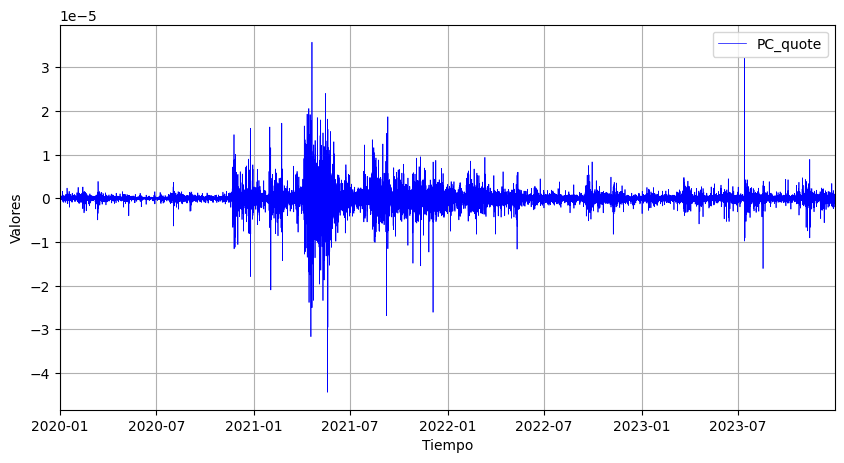

In [ ]:
timeserie_plot(df_timeserie_diff)

In [ ]:
def autotune_arima(df):
    result = adfuller(df)
    print("INITIAL ANALYSIS")
    print("----------------")
    print(f"ADF Statistic (diff): {result[0]}")
    print(f"p-value (diff): {result[1]}")
    df_timeserie = df
    if result[1] > 0.05:
        df_timeserie = df.diff().dropna()
    train, test = timeline_train_test_split(df_timeserie, 0.8)
    model = pm.auto_arima(train['target'], seasonal=False, trace=True)
    model_fit = model.fit()
    start = len(train)
    end = len(train) + len(test) - 1
    predictions = model_fit.predict(start=start, end=end)#, typ='levels')
    plt.figure(figsize=(10, 4))
    plt.plot(train, label='Entrenamiento', linewidth=0.5)
    plt.plot(test, label='Prueba', linewidth=0.5)
    plt.plot(predictions, label='Predicciones', color='red', linewidth=0.5)
    plt.legend()
    plt.show()
    return model, predictions

In [ ]:
autotune_arima(df_timeserie)

INITIAL ANALYSIS
----------------
ADF Statistic (diff): -2.6244813516801004
p-value (diff): 0.08804228985997686
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-591247.758, Time=4.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-660013.658, Time=1.86 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-593452.281, Time=1.75 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-592498.384, Time=2.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-591716.660, Time=2.85 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-605694.532, Time=7.31 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 20.043 seconds


TypeError: ARIMA.fit() missing 1 required positional argument: 'y'

In [ ]:
timeline_train_test_split(df_timeserie)

In [ ]:
start = len(train)
end = len(train) + len(test) - 1
predictions = model_fit.predict(start=start, end=end)#, typ='levels')

NameError: name 'train' is not defined

In [ ]:
train, test = timeserie_train_test_split(df_time_line, 0.8)
print(train.shape, test.shape)
model = pm.auto_arima(train['target'], seasonal=False, trace=True)
model_fit = model.fit()

NameError: name 'df_time_line' is not defined

In [ ]:
start = len(train)
end = len(train) + len(test) - 1
predictions = model_fit.predict(start=start, end=end)#, typ='levels')

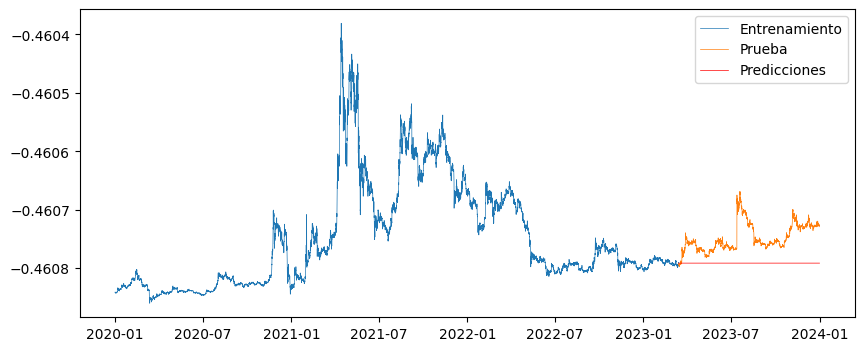

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train, label='Entrenamiento', linewidth=0.5)
plt.plot(test, label='Prueba', linewidth=0.5)
plt.plot(predictions, label='Predicciones', color='red', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
model = pm.auto_arima(train['target'], seasonal=False, trace=True)
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-617118.940, Time=13.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-613736.259, Time=4.91 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-614295.122, Time=6.85 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-621514.319, Time=5.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-636696.904, Time=2.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-652068.956, Time=9.96 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-620883.060, Time=69.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-624525.472, Time=63.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-618094.310, Time=84.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-614506.698, Time=50.42 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-615582.429, Time=43.63 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 354.066 seconds
                               SARIMAX Results                                
Dep. Variable:                    

In [ ]:
predictions = model.predict(n_periods=len(test))

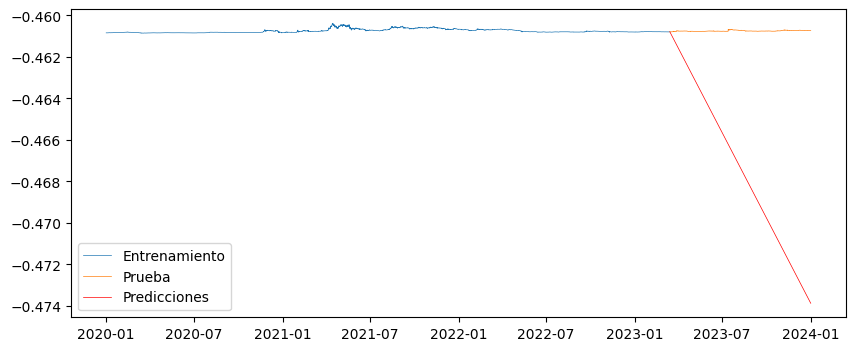

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train, label='Entrenamiento', linewidth=0.5)
plt.plot(test, label='Prueba', linewidth=0.5)
plt.plot(predictions, label='Predicciones', color='red', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
start = len(train)
end = len(train) + len(test) - 1
predictions = model_fit.predict(start=start, end=end)#, typ='levels')

In [ ]:
type(df_price.index)
print(df_price.index.freq)

None


In [ ]:
train, test = timeserie_train_test_split(df_price, 0.8)
print(train.shape, test.shape)

(504553, 1) (126138, 1)


In [ ]:
train

target
date                         
2020-01-01 00:00:00 -0.460841
2020-01-01 01:00:00 -0.460841
2020-01-01 02:00:00 -0.460841
2020-01-01 03:00:00 -0.460841
2020-01-01 04:00:00 -0.460841
...                       ...
2023-05-23 13:00:00 -0.460454
2023-05-23 14:00:00 -0.460453
2023-05-23 15:00:00 -0.460453
2023-05-23 16:00:00 -0.460455
2023-05-23 17:00:00 -0.460455

[504553 rows x 1 columns]

In [ ]:
model = ARIMA(train['target'], order=(5, 1, 0))


c:\Users\Cesar\Documents\Develop\visual\ml-tf\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Cesar\Documents\Develop\visual\ml-tf\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Cesar\Documents\Develop\visual\ml-tf\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Cesar\Documents\Develop\visual\ml-tf\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and 

In [ ]:
import pmdarima as pm

model = pm.auto_arima(train['value'], seasonal=False, trace=True)
print(model.summary())
predictions = model.predict(n_periods=len(test))


## RNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [ ]:
# Función para crear secuencias y etiquetas
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 50
X, y = create_sequences(timeseries['XRP'], seq_length)

X


array([[ 0.        ,  0.09993302,  0.19886554, ..., -0.99997048,
        -0.9957327 , -0.98152597],
       [ 0.09993302,  0.19886554,  0.29580708, ..., -0.9957327 ,
        -0.98152597, -0.95749254],
       [ 0.19886554,  0.29580708,  0.3897871 , ..., -0.98152597,
        -0.95749254, -0.92387301],
       ...,
       [ 0.52014028,  0.60288742,  0.67959865, ..., -0.85805249,
        -0.80243543, -0.73878464],
       [ 0.60288742,  0.67959865,  0.74950597, ..., -0.80243543,
        -0.73878464, -0.6677374 ],
       [ 0.67959865,  0.74950597,  0.81190948, ..., -0.73878464,
        -0.6677374 , -0.59000499]])

In [ ]:
len(data)

1000

In [ ]:
len(X)

950

In [ ]:
len(X[1])

50

In [ ]:
X[1]

array([ 0.09993302,  0.19886554,  0.29580708,  0.3897871 ,  0.47986471,
        0.56513807,  0.64475345,  0.71791378,  0.7838866 ,  0.84201141,
        0.89170627,  0.93247368,  0.96390547,  0.98568695,  0.99760007,
        0.99952556,  0.99144412,  0.97343668,  0.94568351,  0.90846248,
        0.86214622,  0.80719845,  0.74416927,  0.67368972,  0.59646541,
        0.51326949,  0.42493488,  0.33234597,  0.23642973,  0.13814643,
        0.03848005, -0.06157158, -0.16100677, -0.25883002, -0.35406195,
       -0.44574912, -0.53297361, -0.61486214, -0.69059488, -0.75941361,
       -0.82062935, -0.87362922, -0.91788261, -0.95294646, -0.97846973,
       -0.99419689, -0.99997048, -0.9957327 , -0.98152597, -0.95749254])

In [ ]:
12000

In [ ]:
# Redimensionar los datos para que se ajusten al modelo RNN
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
model = Sequential()
model.add(SimpleRNN(50, input_shape=(seq_length, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')